In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sys

In [2]:
from pathlib import Path
sys.path.insert(0,os.path.abspath('../'))
sys.path.insert(0,os.path.abspath('../utilities'))

In [3]:
from utilities.lambda_resnet import lambda_resnet26

In [4]:
from utilities.utils import *

## Lambda Resnet-26 on CIFAR-100

In [5]:
model = lambda_resnet26(num_classes=100)

In [6]:
LABEL='lambda-R26-CIFAR100'

## Getting the hooks for each layers

In [7]:
hookLayersActivationDict = {}
activationDict = {}

In [8]:
modelNamedModules = dict(model.named_modules())

In [9]:
modelNamedModules

{'': LambdaResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): Bottleneck(
       (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (downsample): Sequential(
         (0): Conv2d(64, 256, kerne

In [10]:
hookLayers = []
for i in modelNamedModules.keys():
    if i.__contains__("bn") or i.__contains__("relu") or i.__contains__("norm") or i.__contains__("avgpool") or i.__contains__("fc") or i.__contains__("maxpool") :
        hookLayers.append(i)

In [11]:
for layer in hookLayers:
    h = model.get_submodule(layer).register_forward_hook(getActivation(layer,hookLayersActivationDict))

## CIFAR 100

In [12]:
TRAIN_BATCH_SIZE = 256
TEST_BATCH_SIZE = 256
NUM_WORKERS = 0

normalize = transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                                     std=[0.2675, 0.2565, 0.2761])

train_dataset = datasets.CIFAR100(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True)

train_loader = torch.utils.data.DataLoader(train_dataset,
        batch_size=TRAIN_BATCH_SIZE, shuffle=True,
        num_workers=NUM_WORKERS, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
        datasets.CIFAR100(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=TEST_BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=True)

Files already downloaded and verified


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
model = model.to(device)
valid_acc,activationDict = evaluate(model,device,val_loader,hookLayers,hookLayersActivationDict)

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]


## HSIC calculation and plots

In [15]:
col1,col2,hsicScoreList = getLayerWiseOutputCorrelation(hookLayers,hookLayers,activationDict,activationDict)

In [16]:
import pandas as pd
import seaborn as sns

In [17]:
import matplotlib.ticker as ticker

In [18]:
hsicData = {
    'L1' : col1,
    'L2' : col2,
    'hsic':hsicScoreList
}

hsicDataFrame = pd.DataFrame(data=hsicData)
hsicDataFrame = hsicDataFrame.pivot("L1", "L2", "hsic")

/tmp/ipykernel_1697727/3892509884.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(LABEL+'.pdf',fmt='pdf',bbox_inches='tight')


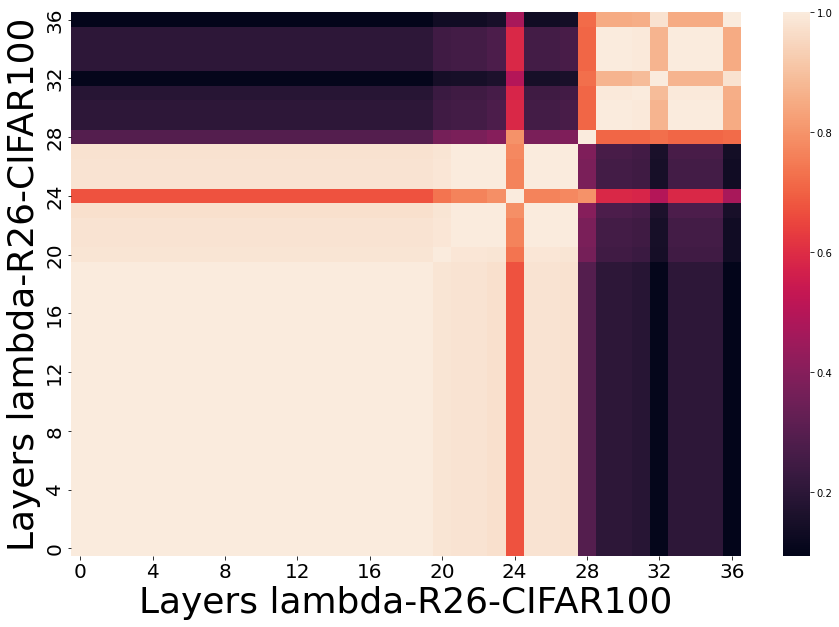

In [19]:
plt.figure(figsize=(15,10))
ax = sns.heatmap(hsicDataFrame.T)
plt.xlabel("Layers "+LABEL,fontsize='36')
plt.ylabel("Layers "+LABEL,fontsize='36')
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xticks(ax.get_xticks()[::4])
ax.set_yticks(ax.get_yticks()[::4])
ax.invert_yaxis()
plt.savefig(LABEL+'.pdf',fmt='pdf',bbox_inches='tight')

In [20]:
hookLayersActivationDict.keys()

dict_keys(['bn1', 'relu', 'maxpool', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.bn2', 'layer1.0.bn3', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.bn2', 'layer1.1.bn3', 'layer2.0.bn1', 'layer2.0.relu', 'layer2.0.bn2', 'layer2.0.bn3', 'layer2.1.bn1', 'layer2.1.relu', 'layer2.1.bn2', 'layer2.1.bn3', 'layer3.0.bn1', 'layer3.0.relu', 'layer3.0.bn2', 'layer3.0.bn3', 'layer3.1.bn1', 'layer3.1.relu', 'layer3.1.bn2', 'layer3.1.bn3', 'layer4.0.bn1', 'layer4.0.relu', 'layer4.0.bn2', 'layer4.0.bn3', 'layer4.1.bn1', 'layer4.1.relu', 'layer4.1.bn2', 'layer4.1.bn3', 'avgpool', 'fc'])

In [21]:
hookLayersActivationDict['bn1'][0].reshape(hookLayersActivationDict['layer4.2.relu2'][0].size(0),-1)

KeyError: 'layer4.2.relu2'

In [ ]:
hookLayersActivationDict['bn1'].size()

In [ ]:
hookLayersActivationDict['bn1'][0].size(0)

In [ ]:
oaL1 = hookLayersActivationDict['bn1'][0].reshape(hookLayersActivationDict['bn1'][0].size(0),-1)

In [ ]:
oaL1.shape

In [ ]:
oaL2 = torch.flatten(hookLayersActivationDict['bn1'][0])

In [ ]:
oaL2